In [ ]:
!pip install scikit-learn imbalanced-learn pandas numpy matplotlib seaborn plotly scipy joblib


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from datetime import datetime
from pathlib import Path

In [ ]:
# CORRECT Timestamp Parsing (year explicitly in format)
def parse_timestamp(date_str):
    try:
        current_year = datetime.now().year
        date_with_year = f"{date_str} {current_year}"
        return datetime.strptime(date_with_year, '%b %d %H:%M:%S %Y')
    except ValueError:
        return pd.NaT

In [ ]:
# Load dataset
df = pd.read_csv(Path('ssh_attacks.csv'))
df['timestamp'] = df['timestamp'].apply(parse_timestamp)

In [ ]:
# Feature Engineering
def prepare_features(df):
    df['hour'] = df['timestamp'].dt.hour
    df['minute'] = df['timestamp'].dt.minute
    df['ip_encoded'] = df['ip'].fillna('unknown').astype('category').cat.codes
    df['user_encoded'] = df['user'].fillna('unknown').astype('category').cat.codes
    df['attempts_per_minute'] = df.groupby(['ip', 'user'])['attempts'].transform('count')
    df['time_diff'] = df['timestamp'].diff().dt.total_seconds().fillna(0)
    df['is_attack'] = ((df['status'] == 'failed') & (df['attempts'] > 3) & (df['time_diff'] < 5)).astype(int)
    return df

In [ ]:
df_processed = prepare_features(df)

In [ ]:
# Select features
available_features = ['hour', 'minute', 'ip_encoded', 'user_encoded', 'attempts', 'time_diff']
features_to_use = [f for f in available_features if f in df_processed.columns]
X = df_processed[features_to_use]
y = df_processed['is_attack']

In [ ]:
print("NaN values in X:")
print(X.isnull().sum())
print("\nNaN values in y:")
print(y.isnull().sum())
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

NaN values in X:
hour            0
minute          0
ip_encoded      0
user_encoded    0
attempts        0
time_diff       0
dtype: int64

NaN values in y:
0
Feature matrix shape: (283, 6)
Target vector shape: (283,)


In [ ]:
# Split en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
# SMOTE sur le training set uniquement
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_res).value_counts())


Class distribution after SMOTE:
is_attack
0    134
1    134
Name: count, dtype: int64


In [ ]:
# Entraînement du modèle
model = make_pipeline(StandardScaler(), RandomForestClassifier(random_state=42))
model.fit(X_train_res, y_train_res)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [ ]:
# Évaluation
print("\nClassification Report:")
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      0.96      0.98        23

    accuracy                           0.98        57
   macro avg       0.99      0.98      0.98        57
weighted avg       0.98      0.98      0.98        57




Confusion Matrix:


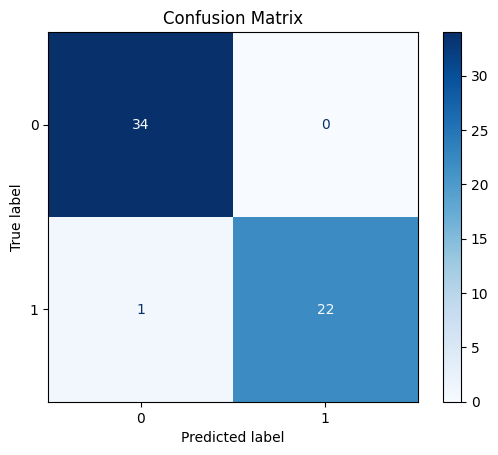

In [ ]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
rf_model = model.steps[1][1]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
print("\nFeature Importances:")
for f in range(X.shape[1]):
    print(f"{features_to_use[indices[f]]}: {importances[indices[f]]:.4f}")


Feature Importances:
time_diff: 0.6149
attempts: 0.3051
minute: 0.0370
user_encoded: 0.0307
hour: 0.0067
ip_encoded: 0.0056


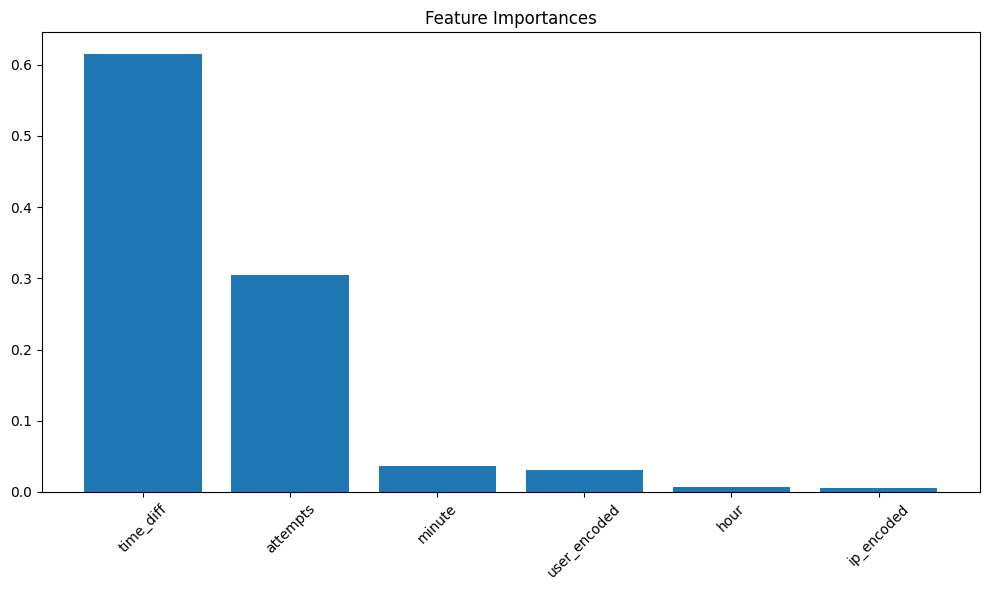

In [ ]:
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [features_to_use[i] for i in indices], rotation=45)
plt.tight_layout()
plt.show()

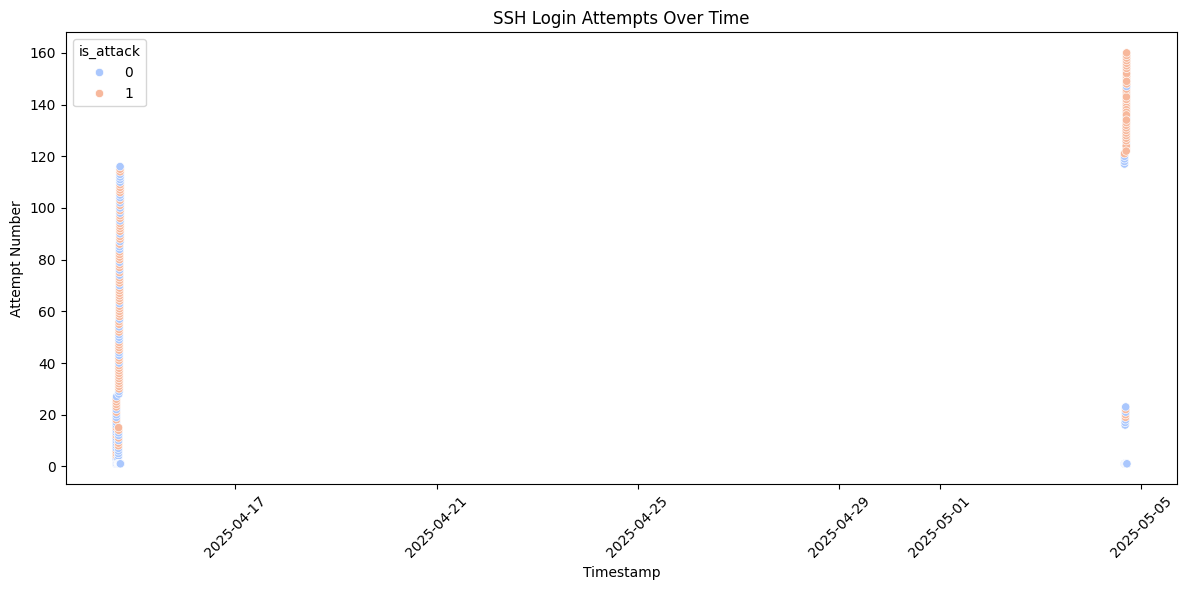

In [ ]:
# Visualisation des attaques
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_processed, x='timestamp', y='attempts', hue='is_attack', palette='coolwarm')
plt.title("SSH Login Attempts Over Time")
plt.xlabel("Timestamp")
plt.ylabel("Attempt Number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du modèle
joblib.dump(model, "ssh_attack_detector.pkl")
print("\nSaved Random Forest model to ssh_attack_detector.pkl")


Saved Random Forest model to ssh_attack_detector.pkl


In [ ]:
# Sauvegarde des encodages
label_encoders = {
    'ip': df['ip'].astype('category').cat.categories.tolist(),
    'user': df['user'].astype('category').cat.categories.tolist()
}
joblib.dump(label_encoders, 'label_encoders.pkl')
print("Saved label encoders to label_encoders.pkl")

Saved label encoders to label_encoders.pkl


In [ ]:
# Simulation en "temps réel"
print("\n=== Simulation temps réel : détection SSH ===")

le_ip = LabelEncoder()
le_user = LabelEncoder()
le_ip.fit(df['ip'])
le_user.fit(df['user'])

for index, row in df.sample(30, random_state=42).iterrows():
    input_data = row.copy()
    try:
        input_data['hour'] = pd.to_datetime(input_data['timestamp'], errors='coerce').hour or 0
    except:
        input_data['hour'] = 0

    input_data['ip_encoded'] = le_ip.transform([input_data['ip']])[0] if input_data['ip'] in le_ip.classes_ else 0
    input_data['user_encoded'] = le_user.transform([input_data['user']])[0] if input_data['user'] in le_user.classes_ else 0
    input_data['minute'] = pd.to_datetime(input_data['timestamp'], errors='coerce').minute or 0
    input_data['time_diff'] = 0  # Approximation simplifiée

    input_features = [[
        input_data['hour'],
        input_data['minute'],
        input_data['ip_encoded'],
        input_data['user_encoded'],
        input_data['attempts'],
        input_data['time_diff']
    ]]

    prediction = model.predict(input_features)[0]
    label = '🔴 ATTAQUE' if prediction == 1 else '🟢 Normal'
    print(f"[{input_data['timestamp']}] Connexion de {row['user']} depuis {row['ip']} => {label}")
    time.sleep(0.5)


=== Simulation temps réel : détection SSH ===
[2025-04-14 15:15:59] Connexion de chaima depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:05:56] Connexion de user2 depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:49:03] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 16:11:16] Connexion de chaima depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:33:31] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:12:21] Connexion de user2 depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:11:51] Connexion de user2 depuis 127.0.0.1 => 🟢 Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 17:01:33] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 15:26:51] Connexion de chaima depuis 127.0.0.1 => 🟢 Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 17:02:09] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:03:52] Connexion de admin depuis unknown => 🟢 Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:12:21] Connexion de user2 depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:55:51] Connexion de test depuis 127.0.0.1 => 🟢 Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:05:56] Connexion de user2 depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 15:15:39] Connexion de chaima depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 16:41:29] Connexion de admin depuis unknown => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:05:56] Connexion de user2 depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 17:03:05] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:00:27] Connexion de testuser depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 15:21:31] Connexion de chaima depuis 127.0.0.1 => 🟢 Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:41:27] Connexion de test depuis 127.0.0.1 => 🟢 Normal


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:20:45] Connexion de admin depuis unknown => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:26:51] Connexion de admin depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 16:41:32] Connexion de admin depuis unknown => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:20:17] Connexion de admin depuis unknown => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:34:48] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:33:39] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 17:01:30] Connexion de test depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-05-04 17:12:21] Connexion de user2 depuis 127.0.0.1 => 🔴 ATTAQUE


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


[2025-04-14 16:41:04] Connexion de test depuis 127.0.0.1 => 🟢 Normal
